In [1]:
import numpy as np
import torch
import torch.nn
import torch.optim
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, ReLU, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, nested_detach
import base_module
from executor import single_train_loop, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging
import logger
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "P4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False

In [4]:
train_configs = {
    ModelType.MLP.name: Config.from_dict({
        "model": "MLP",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 10000,
        "learning_rate": 1e-4,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.PerfNet.name: Config.from_dict({
        "model": "PerfNet",
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 32,
        "eval_steps": 10000,
        "learning_rate": 1e-4,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })
}

model_type = ModelType.MLP
conf = train_configs[model_type.name]

In [5]:
eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=200_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=100_0000)

[2023-12-22 16:10:03,280] {data.py:448} INFO - Loading graphs train
[2023-12-22 16:10:03,281] {data.py:419} INFO - Loading merged.csv
[2023-12-22 16:10:03,281] {data.py:419} INFO - Loading merged.csv
[2023-12-22 16:10:03,779] {data.py:422} INFO - Loaded merged.csv, 200000 rows
[2023-12-22 16:10:03,857] {data.py:428} INFO - Loaded vgg11.57_7.csv, 123 rows
[2023-12-22 16:10:03,947] {data.py:428} INFO - Loaded vgg16.52_7.csv, 173 rows
[2023-12-22 16:10:04,391] {data.py:428} INFO - Loaded rand_2500.176_7.csv, 972 rows
[2023-12-22 16:10:04,528] {data.py:428} INFO - Loaded squeezenet1_1.185_7.csv, 280 rows
[2023-12-22 16:10:05,724] {data.py:428} INFO - Loaded rand_3500.157_7.csv, 2602 rows
[2023-12-22 16:10:05,827] {data.py:428} INFO - Loaded vgg11_bn.89_7.csv, 193 rows
[2023-12-22 16:10:05,879] {data.py:428} INFO - Loaded alexnet.55_7.csv, 89 rows
[2023-12-22 16:10:06,262] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.61_7.csv, 847 rows
[2023-12-22 16:10:06,355] {data.py:428} INFO - Loaded

In [6]:
len(eval_graphs), len(train_graphs)

(224, 651)

In [7]:

def init_dataset(graphs: List[Graph]) -> MDataset:
    op_X, op_Y = list(), list()
    data_idx_to_graph = dict()
    counter = iter(count())
    op_feature_len = 0

    def node_features(g: Graph) -> Tuple[
        List[Dict], List[Dict]]:
        X, Y = list(), list()
        for i, node in enumerate(g.nodes):
            x_op_feature = node.op.to_feature_array("complex")
            x = {
                "x_op_feature": x_op_feature
            }
            # node_durations = (node.duration,node.gap)
            node_durations = (node.duration+node.gap,)
            x["x_id"] = i
            x["x_graph_id"] = g.ID
            y = {"y_node_durations": node_durations, "y_id": i, "y_graph_id": g.ID}
            X.append(x)
            Y.append(y)
        return X, Y

    for graph in graphs:
        X, Y = node_features(graph)
        for x in X:
            # if len(x['x_op_feature'])!=37:
            #     print(x['x_graph_id'], len(x['x_op_feature']))
            op_feature_len = max(op_feature_len, len(x["x_op_feature"]))
        op_X.extend(X)
        op_Y.extend(Y)
        for i in range(len(X)):
            data_idx_to_graph[next(counter)] = graph
    for x in op_X:
        v = x["x_op_feature"]
        x["x_op_feature"] = np.pad(v, (0, op_feature_len - v.size))

    dataset = MDataset(op_X, op_Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [8]:
def get_scalers(ds):
    scaler_cls = normalizer_cls
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array)
    y_array = np.array(y_array)

    op_feature_scaler = scaler_cls()
    op_feature_scaler.fit(op_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return op_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
op_feature_scaler, y_scaler = scalers

In [9]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array, dtype=np.float32)
    y_array = np.array(y_array, dtype=np.float32)


    op_feature_array = op_feature_scaler.transform(op_feature_array)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        processed_features.append({
            "x_id": feature["x_id"],
            "x_graph_id": feature["x_graph_id"],
            # 运行时再传到cuda那边
            # "x_op_feature": torch.Tensor(op_feature_array[i]).to(device=self.conf.device)
            "x_op_feature": torch.Tensor(op_feature_array[i])
        })
        processed_labels.append({
            "y_id": label["y_id"],
            "y_graph_id": label["y_graph_id"],
            # "y_node_durations": torch.Tensor(y_array[i]).to(device=self.conf.device)
            "y_node_durations": torch.Tensor(y_array[i])
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)

In [10]:
# save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, "OpBased", 'train',
#                          conf.dataset_normalization)
# save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, "OpBased", 'eval',
#                          conf.dataset_normalization)
# save_scalers_pkl(scalers, conf.dataset_environment, "OpBased", 'train',
#                          conf.dataset_normalization)

In [11]:
# preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'train', 
#                                          conf.dataset_normalization)
# preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'eval',
#                                         conf.dataset_normalization)
# scalers = load_scalers_pkl(conf.dataset_environment, "OpBased", 'train',
#                            conf.dataset_normalization)


In [12]:
op_feature_scaler, y_scaler = scalers

In [13]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_op_durations(_logits):
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        durations = transformed.sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        op_durations = compute_op_durations(logits)
        for i, graph_id in enumerate(graph_ids):
            op_duration = op_durations[i].item()
            graph_id_to_duration_pred[graph_id] += op_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [14]:

def to_device(conf, features, labels):
    features['x_op_feature'] = features["x_op_feature"].to(device=conf.device)
    labels['y_node_durations'] = labels['y_node_durations'].to(device=conf.device)
    return features, labels

In [15]:
class MLPModel(MModule):

    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }
        # return {}
    
    def __init__(self, input_dimension, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.input = torch.nn.Linear(input_dimension, 256)
        self.relu1 = ReLU()
        self.dense1 = torch.nn.Linear(256, 128)
        self.relu2 = ReLU()
        self.dense2 = torch.nn.Linear(128, 64)
        self.relu3 = ReLU()
        self.output = torch.nn.Linear(64, output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = self.input(X)
        X = self.relu1(X)
        X = self.dense1(X)
        X = self.relu2(X)
        X = self.dense2(X)
        X = self.relu3(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_MLP_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    return MLPModel(input_dimension=len(sample_x_dict["x_op_feature"]),
                    output_dimension=len(sample_y_dict["y_node_durations"]))

In [16]:

class PerfNetModel(MModule):
    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }
        # return {}

    def __init__(self, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.LazyConv1d(out_channels=32, kernel_size=3, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.LazyConv1d(out_channels=128, kernel_size=2, bias=True, padding_mode='zeros')
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(32)
        self.relu1 = ReLU()
        self.dense2 = torch.nn.LazyLinear(64)
        self.relu2 = ReLU()
        self.dense3 = torch.nn.LazyLinear(128)
        self.relu3 = ReLU()
        self.dense4 = torch.nn.LazyLinear(256)
        self.relu4 = ReLU()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.output = torch.nn.LazyLinear(output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = torch.unsqueeze(X, dim=1)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten(X)
        X = self.dense1(X)
        X = self.relu1(X)
        X = self.dense2(X)
        X = self.relu2(X)
        X = self.dense3(X)
        X = self.relu3(X)
        X = self.dense4(X)
        X = self.relu4(X)
        X = self.dropout(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_PerfNet_model() -> MModule | Any:
    sample_y_dict = preprocessed_train_ds.labels[0]
    return PerfNetModel(output_dimension=len(sample_y_dict["y_node_durations"]))



In [20]:
init_model_funcs = {
    ModelType.MLP.name: init_MLP_model,
    ModelType.PerfNet.name: init_PerfNet_model,
}

model_type = ModelType.PerfNet
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[2023-12-22 16:29:34,494] {executor.py:148} INFO - ModelType.PerfNet start single training.
[2023-12-22 16:29:34,495] {executor.py:150} INFO - ModelType.PerfNet training epoch 0


  0%|          | 0/19595 [00:00<?, ?it/s]

[2023-12-22 16:29:35,553] {executor.py:111} INFO - ModelType.PerfNet trained for 1.058736326 seconds.
[2023-12-22 16:29:35,553] {executor.py:112} INFO - ModelType.PerfNet eval at step 0.
[2023-12-22 16:29:41,904] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.1762014627456665, eval metrics: {'eval_loss': 0.20858157476007938, 'MRE': 0.6220755785785913, 'MAE': 0.6475809569648698, 'RMSE': 487.90304854131483}
[2023-12-22 16:29:41,929] {executor.py:187} INFO - Saving model at step 0 with loss 0.1762014627456665,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 51%|█████     | 9991/19595 [00:43<00:35, 270.25it/s]

[2023-12-22 16:30:17,941] {executor.py:111} INFO - ModelType.PerfNet trained for 43.446978398 seconds.
[2023-12-22 16:30:17,942] {executor.py:112} INFO - ModelType.PerfNet eval at step 10000.
[2023-12-22 16:30:24,272] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.06975597888231277, eval metrics: {'eval_loss': 0.07553961701210589, 'MRE': 0.1654704213081552, 'MAE': 0.26190040350975996, 'RMSE': 363.01802625107905}
[2023-12-22 16:30:24,297] {executor.py:187} INFO - Saving model at step 10000 with loss 0.06975597888231277,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:24<00:00, 232.18it/s]

[2023-12-22 16:30:58,895] {executor.py:150} INFO - ModelType.PerfNet training epoch 1



  2%|▏         | 375/19595 [00:01<01:04, 298.95it/s]

[2023-12-22 16:31:00,322] {executor.py:111} INFO - ModelType.PerfNet trained for 85.827948047 seconds.
[2023-12-22 16:31:00,322] {executor.py:112} INFO - ModelType.PerfNet eval at step 20000.
[2023-12-22 16:31:06,202] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03171343356370926, eval metrics: {'eval_loss': 0.06942432688925415, 'MRE': 0.20617003058169273, 'MAE': 0.2844742634371654, 'RMSE': 368.8671612421745}
[2023-12-22 16:31:06,224] {executor.py:187} INFO - Saving model at step 20000 with loss 0.03171343356370926,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 53%|█████▎    | 10384/19595 [00:42<00:32, 282.47it/s]

[2023-12-22 16:31:41,912] {executor.py:111} INFO - ModelType.PerfNet trained for 127.418517918 seconds.
[2023-12-22 16:31:41,913] {executor.py:112} INFO - ModelType.PerfNet eval at step 30000.
[2023-12-22 16:31:48,145] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.025037921965122223, eval metrics: {'eval_loss': 0.06540106322683394, 'MRE': 0.1666037341347344, 'MAE': 0.240759675013295, 'RMSE': 356.9914650738407}
[2023-12-22 16:31:48,168] {executor.py:187} INFO - Saving model at step 30000 with loss 0.025037921965122223,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:22<00:00, 238.08it/s]

[2023-12-22 16:32:21,204] {executor.py:150} INFO - ModelType.PerfNet training epoch 2



  4%|▍         | 802/19595 [00:02<01:04, 290.32it/s]

[2023-12-22 16:32:24,106] {executor.py:111} INFO - ModelType.PerfNet trained for 169.612211853 seconds.
[2023-12-22 16:32:24,107] {executor.py:112} INFO - ModelType.PerfNet eval at step 40000.
[2023-12-22 16:32:30,167] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.036249592900276184, eval metrics: {'eval_loss': 0.0658452910637483, 'MRE': 0.1708547495497476, 'MAE': 0.2598825332712172, 'RMSE': 364.9338448649005}
[2023-12-22 16:32:30,192] {executor.py:187} INFO - Saving model at step 40000 with loss 0.036249592900276184,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 55%|█████▌    | 10810/19595 [00:45<00:31, 278.97it/s]

[2023-12-22 16:33:06,389] {executor.py:111} INFO - ModelType.PerfNet trained for 211.895254159 seconds.
[2023-12-22 16:33:06,390] {executor.py:112} INFO - ModelType.PerfNet eval at step 50000.
[2023-12-22 16:33:15,102] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.12974348664283752, eval metrics: {'eval_loss': 0.0655421695487015, 'MRE': 0.1428744582879909, 'MAE': 0.234649344284062, 'RMSE': 369.2951926515589}
[2023-12-22 16:33:15,127] {executor.py:187} INFO - Saving model at step 50000 with loss 0.12974348664283752,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:25<00:00, 230.31it/s]

[2023-12-22 16:33:46,287] {executor.py:150} INFO - ModelType.PerfNet training epoch 3



  6%|▌         | 1202/19595 [00:04<01:06, 278.25it/s]

[2023-12-22 16:33:50,732] {executor.py:111} INFO - ModelType.PerfNet trained for 256.237698711 seconds.
[2023-12-22 16:33:50,732] {executor.py:112} INFO - ModelType.PerfNet eval at step 60000.
[2023-12-22 16:33:56,689] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03673703223466873, eval metrics: {'eval_loss': 0.06385360643718392, 'MRE': 0.13295151930284832, 'MAE': 0.20378962839149825, 'RMSE': 342.32363147305216}
[2023-12-22 16:33:56,713] {executor.py:187} INFO - Saving model at step 60000 with loss 0.03673703223466873,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 57%|█████▋    | 11209/19595 [00:46<00:30, 277.60it/s]

[2023-12-22 16:34:32,719] {executor.py:111} INFO - ModelType.PerfNet trained for 298.224787935 seconds.
[2023-12-22 16:34:32,719] {executor.py:112} INFO - ModelType.PerfNet eval at step 70000.
[2023-12-22 16:34:38,857] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03805188834667206, eval metrics: {'eval_loss': 0.06429521828722208, 'MRE': 0.15471478767226982, 'MAE': 0.21923187890587162, 'RMSE': 337.1501380792249}
[2023-12-22 16:34:38,882] {executor.py:187} INFO - Saving model at step 70000 with loss 0.03805188834667206,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:22<00:00, 236.25it/s]

[2023-12-22 16:35:09,231] {executor.py:150} INFO - ModelType.PerfNet training epoch 4



  8%|▊         | 1594/19595 [00:05<01:03, 285.19it/s]

[2023-12-22 16:35:14,970] {executor.py:111} INFO - ModelType.PerfNet trained for 340.476664375 seconds.
[2023-12-22 16:35:14,971] {executor.py:112} INFO - ModelType.PerfNet eval at step 80000.
[2023-12-22 16:35:20,954] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.02865101769566536, eval metrics: {'eval_loss': 0.06446003814790398, 'MRE': 0.17930911991949433, 'MAE': 0.2658056220309814, 'RMSE': 378.31256308748067}
[2023-12-22 16:35:20,979] {executor.py:187} INFO - Saving model at step 80000 with loss 0.02865101769566536,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 59%|█████▉    | 11615/19595 [00:47<00:29, 275.01it/s]

[2023-12-22 16:35:56,808] {executor.py:111} INFO - ModelType.PerfNet trained for 382.31380187 seconds.
[2023-12-22 16:35:56,808] {executor.py:112} INFO - ModelType.PerfNet eval at step 90000.
[2023-12-22 16:36:02,863] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03358253464102745, eval metrics: {'eval_loss': 0.06164121224753558, 'MRE': 0.1334325068664252, 'MAE': 0.21579450114383178, 'RMSE': 351.98747684715823}
[2023-12-22 16:36:02,886] {executor.py:187} INFO - Saving model at step 90000 with loss 0.03358253464102745,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:22<00:00, 238.13it/s]

[2023-12-22 16:36:31,522] {executor.py:150} INFO - ModelType.PerfNet training epoch 5



 10%|█         | 2004/19595 [00:07<01:02, 281.54it/s]

[2023-12-22 16:36:38,706] {executor.py:111} INFO - ModelType.PerfNet trained for 424.211985275 seconds.
[2023-12-22 16:36:38,706] {executor.py:112} INFO - ModelType.PerfNet eval at step 100000.
[2023-12-22 16:36:44,703] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.025251396000385284, eval metrics: {'eval_loss': 0.0585633649155125, 'MRE': 0.12884011261470976, 'MAE': 0.1968302476438582, 'RMSE': 345.92561314669365}
[2023-12-22 16:36:44,726] {executor.py:187} INFO - Saving model at step 100000 with loss 0.025251396000385284,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 61%|██████▏   | 12019/19595 [00:49<00:27, 274.75it/s]

[2023-12-22 16:37:20,742] {executor.py:111} INFO - ModelType.PerfNet trained for 466.248288082 seconds.
[2023-12-22 16:37:20,743] {executor.py:112} INFO - ModelType.PerfNet eval at step 110000.
[2023-12-22 16:37:26,932] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.026080351322889328, eval metrics: {'eval_loss': 0.062420768440365794, 'MRE': 0.17253668660280044, 'MAE': 0.25489929761740604, 'RMSE': 371.0805901640344}
[2023-12-22 16:37:26,955] {executor.py:187} INFO - Saving model at step 110000 with loss 0.026080351322889328,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:22<00:00, 237.51it/s]

[2023-12-22 16:37:54,028] {executor.py:150} INFO - ModelType.PerfNet training epoch 6



 12%|█▏        | 2420/19595 [00:08<01:03, 272.10it/s]

[2023-12-22 16:38:03,010] {executor.py:111} INFO - ModelType.PerfNet trained for 508.515648285 seconds.
[2023-12-22 16:38:03,010] {executor.py:112} INFO - ModelType.PerfNet eval at step 120000.
[2023-12-22 16:38:09,273] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.041047051548957825, eval metrics: {'eval_loss': 0.06345706976357847, 'MRE': 0.14859806052113292, 'MAE': 0.23577757355868467, 'RMSE': 367.6718725016491}
[2023-12-22 16:38:09,296] {executor.py:187} INFO - Saving model at step 120000 with loss 0.041047051548957825,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 63%|██████▎   | 12423/19595 [00:51<00:26, 272.84it/s]

[2023-12-22 16:38:45,983] {executor.py:111} INFO - ModelType.PerfNet trained for 551.489079864 seconds.
[2023-12-22 16:38:45,984] {executor.py:112} INFO - ModelType.PerfNet eval at step 130000.
[2023-12-22 16:38:52,116] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.061055053025484085, eval metrics: {'eval_loss': 0.05859494207171723, 'MRE': 0.1574180364718783, 'MAE': 0.22087298241015355, 'RMSE': 341.61234714813605}
[2023-12-22 16:38:52,140] {executor.py:187} INFO - Saving model at step 130000 with loss 0.061055053025484085,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:23<00:00, 233.34it/s]

[2023-12-22 16:39:18,008] {executor.py:150} INFO - ModelType.PerfNet training epoch 7



 14%|█▍        | 2821/19595 [00:10<01:01, 273.43it/s]

[2023-12-22 16:39:28,218] {executor.py:111} INFO - ModelType.PerfNet trained for 593.724230223 seconds.
[2023-12-22 16:39:28,219] {executor.py:112} INFO - ModelType.PerfNet eval at step 140000.
[2023-12-22 16:39:34,574] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03602824732661247, eval metrics: {'eval_loss': 0.057523862569592896, 'MRE': 0.13853840517432686, 'MAE': 0.19555743378238927, 'RMSE': 330.96464342970006}
[2023-12-22 16:39:34,596] {executor.py:187} INFO - Saving model at step 140000 with loss 0.03602824732661247,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 65%|██████▌   | 12813/19595 [00:52<00:24, 274.28it/s]

[2023-12-22 16:40:10,677] {executor.py:111} INFO - ModelType.PerfNet trained for 636.183387966 seconds.
[2023-12-22 16:40:10,678] {executor.py:112} INFO - ModelType.PerfNet eval at step 150000.
[2023-12-22 16:40:16,829] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.05241617187857628, eval metrics: {'eval_loss': 0.055418575123716146, 'MRE': 0.12815974799892743, 'MAE': 0.1893658668156447, 'RMSE': 335.1862564488879}
[2023-12-22 16:40:16,852] {executor.py:187} INFO - Saving model at step 150000 with loss 0.05241617187857628,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:23<00:00, 234.26it/s]

[2023-12-22 16:40:41,658] {executor.py:150} INFO - ModelType.PerfNet training epoch 8



 16%|█▋        | 3219/19595 [00:11<01:00, 272.64it/s]

[2023-12-22 16:40:53,555] {executor.py:111} INFO - ModelType.PerfNet trained for 679.061562814 seconds.
[2023-12-22 16:40:53,556] {executor.py:112} INFO - ModelType.PerfNet eval at step 160000.
[2023-12-22 16:40:59,733] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.0213717482984066, eval metrics: {'eval_loss': 0.0563987555058673, 'MRE': 0.13650930756722196, 'MAE': 0.21125074431210172, 'RMSE': 346.2852659458658}
[2023-12-22 16:40:59,758] {executor.py:187} INFO - Saving model at step 160000 with loss 0.0213717482984066,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 67%|██████▋   | 13216/19595 [00:54<00:23, 274.54it/s]

[2023-12-22 16:41:36,111] {executor.py:111} INFO - ModelType.PerfNet trained for 721.617195919 seconds.
[2023-12-22 16:41:36,112] {executor.py:112} INFO - ModelType.PerfNet eval at step 170000.
[2023-12-22 16:41:42,331] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.036795731633901596, eval metrics: {'eval_loss': 0.058367987816315144, 'MRE': 0.13864708477700466, 'MAE': 0.20054894800292522, 'RMSE': 334.9565348379332}
[2023-12-22 16:41:42,354] {executor.py:187} INFO - Saving model at step 170000 with loss 0.036795731633901596,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:23<00:00, 233.40it/s]

[2023-12-22 16:42:05,615] {executor.py:150} INFO - ModelType.PerfNet training epoch 9



 19%|█▊        | 3630/19595 [00:13<00:58, 271.48it/s]

[2023-12-22 16:42:18,842] {executor.py:111} INFO - ModelType.PerfNet trained for 764.348061439 seconds.
[2023-12-22 16:42:18,842] {executor.py:112} INFO - ModelType.PerfNet eval at step 180000.
[2023-12-22 16:42:25,047] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.0813668817281723, eval metrics: {'eval_loss': 0.056688834090624, 'MRE': 0.13195777612943668, 'MAE': 0.20759319504215118, 'RMSE': 345.28380634008334}
[2023-12-22 16:42:25,069] {executor.py:187} INFO - Saving model at step 180000 with loss 0.0813668817281723,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


 70%|██████▉   | 13633/19595 [00:55<00:21, 280.23it/s]

[2023-12-22 16:43:01,143] {executor.py:111} INFO - ModelType.PerfNet trained for 806.649388998 seconds.
[2023-12-22 16:43:01,144] {executor.py:112} INFO - ModelType.PerfNet eval at step 190000.
[2023-12-22 16:43:07,358] {executor.py:116} INFO - ModelType.PerfNet train loss: 0.03755595535039902, eval metrics: {'eval_loss': 0.055686688737682996, 'MRE': 0.1245306605152346, 'MAE': 0.17920034555529865, 'RMSE': 326.41419852422473}
[2023-12-22 16:43:07,380] {executor.py:187} INFO - Saving model at step 190000 with loss 0.03755595535039902,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/P4_CPUALL/PerfNet/single_train2023-12-22_16-29-34


100%|██████████| 19595/19595 [01:23<00:00, 233.93it/s]


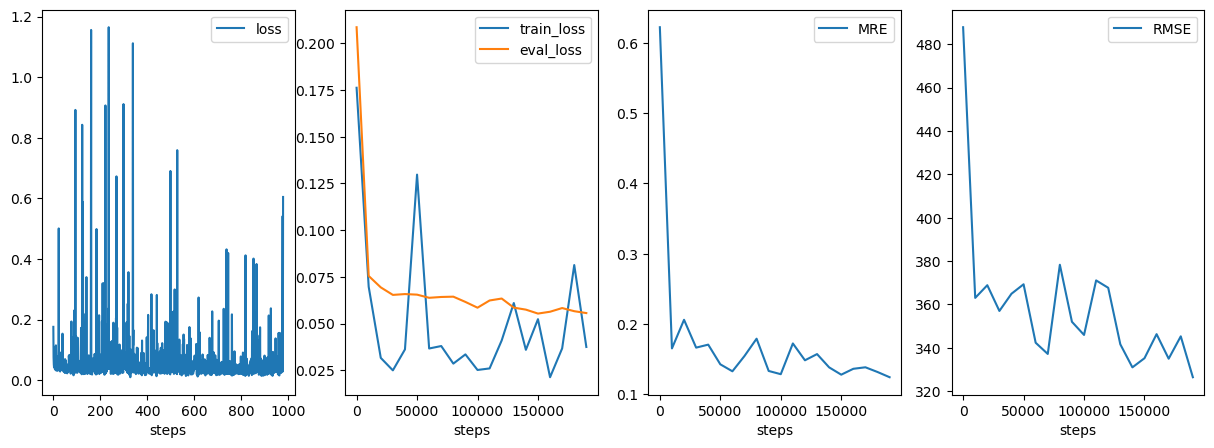

In [21]:
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

In [19]:
from executor import grid_search_loop
# reload(executor)
# grid_search_loop(
#     model_type,
#     conf,
#     preprocessed_train_ds,
#     preprocessed_eval_ds,
#     compute_evaluate_metrics,
#     to_device,
#     init_model,
# )